## Controlling webcam

In [ ]:
import numpy as np
import cv2 as cv
from PIL import Image
import ipywidgets
from IPython.display import clear_output
import os

In [ ]:
from io import BytesIO
import IPython.display
import PIL.Image

INTERFACE = "usb" # usb, csi

def get_source(id, interface=INTERFACE):
    if id == "left":
        id = 0
    elif id == "right":
        id = 1

    if interface == "usb":
        return id
    elif interface == "csi":
        return (
            "nvarguscamerasrc sensor-id=%d sensor-mode=%d ! "
            "video/x-raw(memory:NVMM), "
            "width=(int)%d, height=(int)%d, "
            "format=(string)NV12, framerate=(fraction)%d/1 ! "
            "nvvidconv flip-method=%d ! "
            "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
            "videoconvert ! "
            "video/x-raw, format=(string)BGR ! appsink"
            % (
                id, # camera id
                3, # mode
                640, # width
                480, # height
                10, # frame rate
                0, # flip method
                640, # display width
                480, # display height
            )
        )
    else:
        raise Exception("Unknown camera source.")

def camera_capture(id):
    camera = cv.VideoCapture(get_source(id))
    camera.set(cv.CAP_PROP_FRAME_WIDTH, 1280)
    camera.set(cv.CAP_PROP_FRAME_HEIGHT, 1024)
    ret, image = camera.read()

    if not ret:
        return None

    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    camera.release()
    return image

def camera_capture2():
    left = cv.VideoCapture(get_source("left"))
    left.set(cv.CAP_PROP_FRAME_WIDTH, 1280)
    left.set(cv.CAP_PROP_FRAME_HEIGHT, 1024)

    right = cv.VideoCapture(get_source("right"))
    right.set(cv.CAP_PROP_FRAME_WIDTH, 1280)
    right.set(cv.CAP_PROP_FRAME_HEIGHT, 1024)

    if not (left.grab() and right.grab()):
        return None

    _, left_frame = left.retrieve()
    _, right_frame = right.retrieve()

    left_frame = cv.cvtColor(left_frame, cv.COLOR_BGR2GRAY)
    right_frame = cv.cvtColor(right_frame, cv.COLOR_BGR2GRAY)

    left.release()
    right.release()
    return np.hstack((left_frame, right_frame))

def camera_stream(id):
    camera = cv.VideoCapture(get_source(id))
    camera.set(3, 1280)
    camera.set(4, 1024)
    try: 
        while True:
            ret, frame = camera.read()
            frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

            frame = cv.rotate(frame, cv.ROTATE_90_COUNTERCLOCKWISE)

            stream = BytesIO()
            PIL.Image.fromarray(frame).save(stream, format="jpeg")
            IPython.display.display(IPython.display.Image(data=stream.getvalue()))

            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        camera.release()
        print("Stream Stopped")
        
def camera_stream2():
    camera0 = cv.VideoCapture(get_source(0))
    camera0.set(cv.CAP_PROP_FRAME_WIDTH, 1280)
    camera0.set(cv.CAP_PROP_FRAME_HEIGHT, 1024)

    camera1 = cv.VideoCapture(get_source(1))
    camera1.set(cv.CAP_PROP_FRAME_WIDTH, 1280)
    camera1.set(cv.CAP_PROP_FRAME_HEIGHT, 1024)
    try: 
        while True:
            camera0.grab()
            camera1.grab()

            _, frame0 = camera0.retrieve()
            _, frame1 = camera1.retrieve()

            frame0 = cv.cvtColor(frame0, cv.COLOR_BGR2GRAY)
            frame1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
            
            frame = np.hstack((frame0, frame1))
            
            # frame = cv.flip(frame, 1)

            stream = BytesIO()
            PIL.Image.fromarray(frame).save(stream, format="jpeg")
    
            IPython.display.display(IPython.display.Image(data=stream.getvalue()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        camera0.release()
        camera1.release()
        print("Stream Stopped")

In [ ]:
camera_stream2()

## Calibration

### Collecting images

In [ ]:
left = camera_capture(get_source("left"))
right = camera_capture(get_source("right"))

count = len(os.listdir("calibration/left"))
Image.fromarray(left).save("calibration/left/" + str(count) + ".jpg"))

count = len(os.listdir("calibration/right"))
Image.fromarray(right).save(os.path.join("calibration/right/" + str(count) + ".jpg"))

display(Image.fromarray(np.hstack((left, right))))

### Loading images

In [112]:
left_images = []
right_images = []

for f in os.listdir("calibration/left"):
    image = cv.imread("calibration/left/" + f)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    left_images.append(image)

for f in os.listdir("calibration/right"):
    image = cv.imread("calibration/right/" + f)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    right_images.append(image)

if len(left_images) == len(right_images):
    images_num = len(left_images)
    print("Loaded", images_num, "* 2 images.")
else:
    print("The number of right and left images are different!")

Loaded 74 * 2 images.


### Finding chessboard corners

In [136]:
obj_points = []
left_image_points = []
right_image_points = []

for idx, (left_image, right_image) in enumerate(zip(left_images, right_images)):
    print("Processing pair", idx, end=": ")
    ret_left, corners_left = cv.findChessboardCorners(left_image, (7, 7), cv.CALIB_CB_FAST_CHECK)
    ret_right, corners_right = cv.findChessboardCorners(right_image, (7, 7), cv.CALIB_CB_FAST_CHECK)

    if not (ret_left and ret_right):
        print("ERROR")
        continue

    obj = np.zeros((7 * 7, 3), np.float32)
    obj[:, :2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2)
    obj_points.append(obj)

    left_image_points.append(corners_left)
    right_image_points.append(corners_right)
     
    print("OK")

Processing pair 0: OK
Processing pair 1: OK
Processing pair 2: OK
Processing pair 3: OK
Processing pair 4: OK
Processing pair 5: OK
Processing pair 6: OK
Processing pair 7: OK
Processing pair 8: OK
Processing pair 9: OK
Processing pair 10: OK
Processing pair 11: OK
Processing pair 12: OK
Processing pair 13: OK
Processing pair 14: OK
Processing pair 15: ERROR
Processing pair 16: OK
Processing pair 17: OK
Processing pair 18: OK
Processing pair 19: ERROR
Processing pair 20: OK
Processing pair 21: ERROR
Processing pair 22: OK
Processing pair 23: OK
Processing pair 24: OK
Processing pair 25: OK
Processing pair 26: OK
Processing pair 27: OK
Processing pair 28: OK
Processing pair 29: OK
Processing pair 30: OK
Processing pair 31: OK
Processing pair 32: ERROR
Processing pair 33: OK
Processing pair 34: ERROR
Processing pair 35: OK
Processing pair 36: ERROR
Processing pair 37: OK
Processing pair 38: OK
Processing pair 39: OK
Processing pair 40: OK
Processing pair 41: OK
Processing pair 42: OK
Pro

### Calculating distortions

In [138]:
print("Calibrating left camera...")
_, left_matrix, left_distortion_coeff, _, _ = cv.calibrateCamera(
    obj_points, 
    left_image_points,
    (1024, 1280), None, None
)

print("Calibrating right camera...")
_, right_matrix, right_distortion_coeff, _, _ = cv.calibrateCamera(
    obj_points, 
    right_image_points,
    (1024, 1280), None, None
)

# new_camera_matrix, roi = cv.getOptimalNewCameraMatrix(matrix, distortion_coeff, (1024, 1280), 1, (1024, 1280))

Calibrating left camera...
Calibrating right camera...


In [140]:
print("Calibrating cameras together...")
_, _, _, _, _, rotation_matrix, translation_vector, _, _ = cv.stereoCalibrate(
    obj_points,
    left_image_points, right_image_points,
    left_matrix, left_distortion_coeff,
    right_matrix, right_distortion_coeff,
    (1024, 1280), None, None, None, None,
    cv.CALIB_FIX_INTRINSIC,
)

Calibrating cameras together...


In [142]:
print("Rectifying cameras...")
left_rectification, right_rectification, left_projection, right_projection, _, left_roi, right_roi = cv.stereoRectify(
    left_matrix, left_distortion_coeff,
    right_matrix, right_distortion_coeff,
    (1024, 1280), rotation_matrix, translation_vector,
    None, None, None, None, None,
    cv.CALIB_ZERO_DISPARITY, 0.25,
)

Rectifying cameras...


In [144]:
left_max_x, left_map_y = cv.initUndistortRectifyMap(
    left_matrix, left_distortion_coeff, left_rectification,
    left_projection, (1024, 1280), cv.CV_32FC1
)

right_max_x, right_map_y = cv.initUndistortRectifyMap(
    right_matrix, right_distortion_coeff, right_rectification,
    right_projection, (1024, 1280), cv.CV_32FC1
)

np.savez_compressed("stereo.npz", 
    left_max_x=left_max_x, left_map_y=left_map_y, left_roi=left_roi,
    right_max_x=right_max_x, right_map_y=right_map_y, right_roi=right_roi
)

In [146]:
calibration = np.load("stereo.npz", allow_pickle=False)
left_max_x = calibration["left_max_x"]
left_map_y = calibration["left_map_y"]
left_roi = tuple(calibration["left_roi"])
right_max_x = calibration["right_max_x"]
right_map_y = calibration["right_map_y"]
right_roi = tuple(calibration["right_roi"])

In [148]:
stereo = cv.StereoBM_create()
stereo.setMinDisparity(4)
stereo.setNumDisparities(128)
stereo.setBlockSize(21)
stereo.setROI1(left_roi)
stereo.setROI2(right_roi)
stereo.setSpeckleRange(16)
stereo.setSpeckleWindowSize(45)

In [151]:
left = camera_capture(0)
right = camera_capture(1)

In [155]:
fixed_left = cv.remap(left, left_max_x, left_map_y, cv2.INTER_LINEAR)
fixed_right = cv.remap(right, right_max_x, right_map_y, cv2.INTER_LINEAR)

depth = stereo.compute(fixed_left, fixed_right)

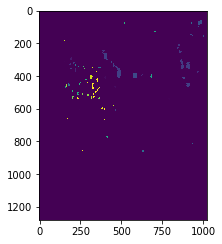

In [162]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(3, 20))
plt.imshow(depth / 2048)

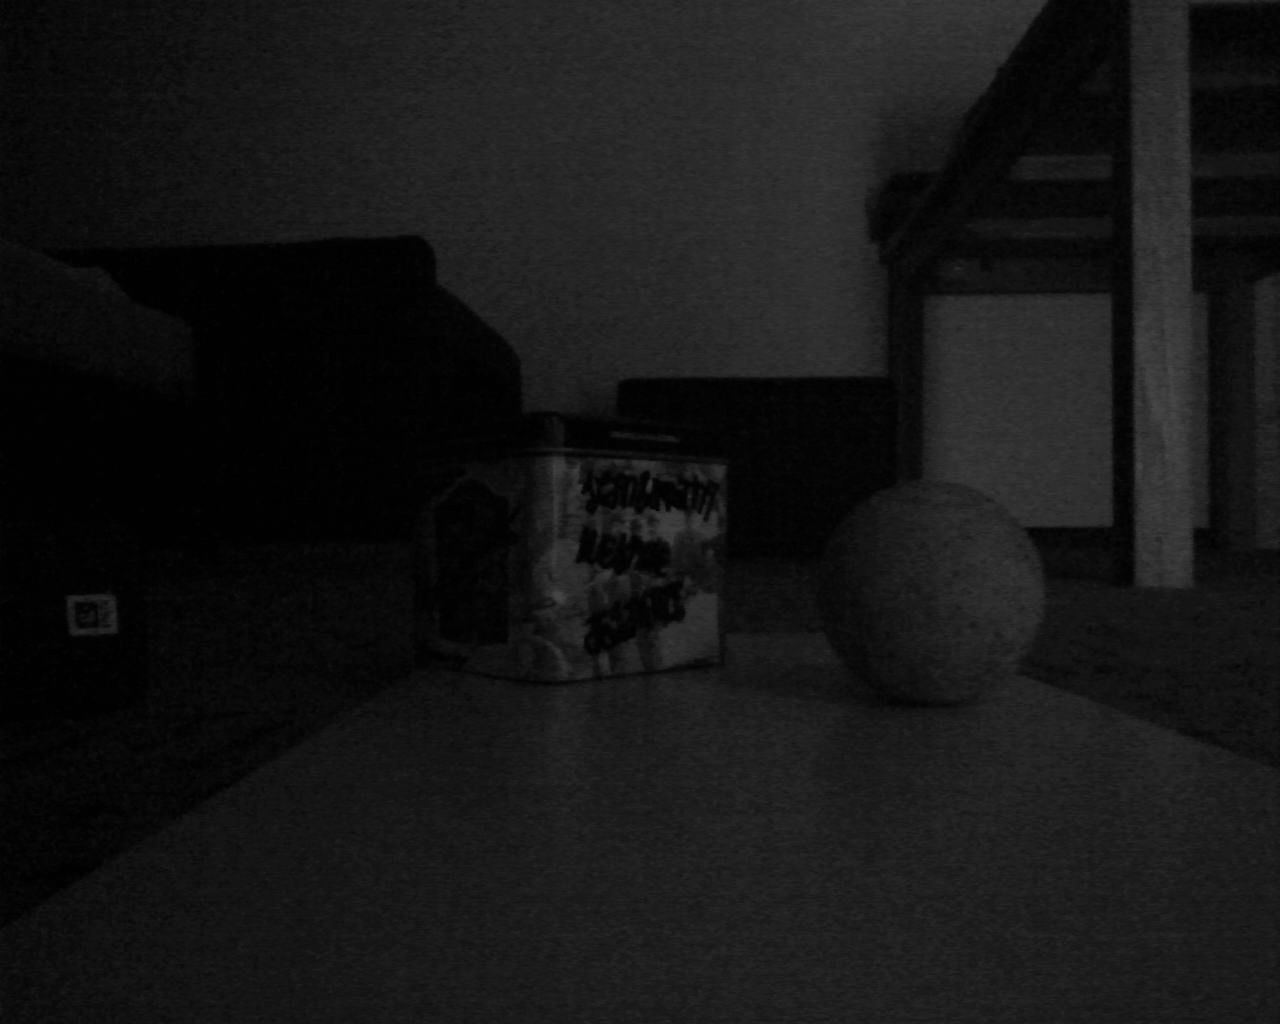

In [159]:
display(Image.fromarray(left))

# ---------

In [ ]:
for idx, image in enumerate(images):
    image_undist = cv.undistort(image, matrix, distortion_coeff, None, new_camera_matrix)
    Image.fromarray(image_undist).save(os.path.join("calibration-undistorted", str(idx) + ".jpg"))

    x, y, w, h = roi
    image_undist_roi = image_undist[y:y + h, x:x + w]
    Image.fromarray(image_undist_roi).save(os.path.join("calibration-undistorted-roi", str(idx) + ".jpg"))

### Calculating re-projection error

In [ ]:
mean_error = 0
for i in range(len(obj_points)):
    img_points2, _ = cv.projectPoints(obj_points[i], rotation_vec[i], translation_vec[i], matrix, distortion_coeff)
    mean_error += cv.norm(img_points[i], img_points2, cv.NORM_L2) / len(img_points2)

print("Total error:", mean_error / len(obj_points))

### Saving coefficients

In [ ]:
np.savez("logitech-500.npz", 
    matrix=matrix,
    distortion_coeff=distortion_coeff,
    rotation_vec=rotation_vec,
    translation_vec=translation_vec,
    new_camera_matrix=new_camera_matrix,
    roi=roi)

coefficients = dict(np.load("logitech-500.npz"))

## Pose Estimation

In [ ]:
coefficients = dict(np.load("logitech-500.npz"))
matrix, distortion_coeff = coefficients["matrix"], coefficients["distortion_coeff"]

In [ ]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

In [ ]:
camera = cv.VideoCapture(get_source(0))
camera.set(3, 640)
camera.set(4, 480)
try: 
    while True:
        obj_points = []
        img_points = []

        ret, frame = camera.read()
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        frame = cv.rotate(frame, cv.ROTATE_90_COUNTERCLOCKWISE)

        ret, corners = cv.findChessboardCorners(frame, (7,7), None)
        if ret:
            obj = np.zeros((7 * 7, 3), np.float32)
            obj[:, :2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2)
            obj_points.append(obj)
            ret, rvecs, tvecs = cv.solvePnP(obj, corners, matrix, distortion_coeff)

            axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
            img_points, jac = cv.projectPoints(axis, rvecs, tvecs, matrix, distortion_coeff)

            frame = cv.cvtColor(frame, cv.COLOR_GRAY2RGB)
            frame = draw(frame, corners, img_points)

        stream = BytesIO()
        PIL.Image.fromarray(frame).save(stream, format="jpeg")
        IPython.display.display(IPython.display.Image(data=stream.getvalue()))

        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    camera.release()
    print("Stream Stopped")

## Depth map

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ID_LEFT = 0
ID_RIGHT = 1

# left, right = camera_capture(ID_LEFT), camera_capture(ID_RIGHT)
left, right = cv.imread("left.jpg"), cv.imread("right.jpg")
left, right = cv.cvtColor(left, cv.COLOR_BGR2GRAY), cv.cvtColor(right, cv.COLOR_BGR2GRAY)

stereo = cv.StereoBM_create(numDisparities=16, blockSize=5)
disparity = stereo.compute(left, right)

plt.subplots(figsize=(20, 20))
plt.imshow(disparity)

In [ ]:
left = cv.rotate(camera_capture(0), cv.ROTATE_90_COUNTERCLOCKWISE)
Image.fromarray(left).save("left.jpg")
display(Image.fromarray(left))

In [ ]:
right = cv.rotate(camera_capture(0), cv.ROTATE_90_COUNTERCLOCKWISE)
Image.fromarray(right).save("right.jpg")
display(Image.fromarray(right))

In [ ]:
coefficients = dict(np.load("logitech-500.npz"))
matrix, distortion_coeff, new_camera_matrix = coefficients["matrix"], coefficients["distortion_coeff"], coefficients["new_camera_matrix"]

In [ ]:
left_undist = cv.undistort(left, matrix, distortion_coeff, None, new_camera_matrix)

x, y, w, h = roi
left_undist = left_undist[y:y + h, x:x + w]

display(Image.fromarray(left_undist))

In [ ]:
right_undist = cv.undistort(right, matrix, distortion_coeff, None, new_camera_matrix)

x, y, w, h = roi
right_undist = right_undist[y:y + h, x:x + w]

display(Image.fromarray(right_undist))

In [ ]:
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(left, right)

plt.subplots(figsize=(20, 20))
plt.imshow(disparity)